In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras import datasets, layers, models


from keras.layers import Dense
from keras import datasets, layers, models
import math

from sklearn.cluster import KMeans
import tensorflow as tf
from keras import layers, datasets, models
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense



In [ ]:
df = pd.read_csv("/content/Train.csv")

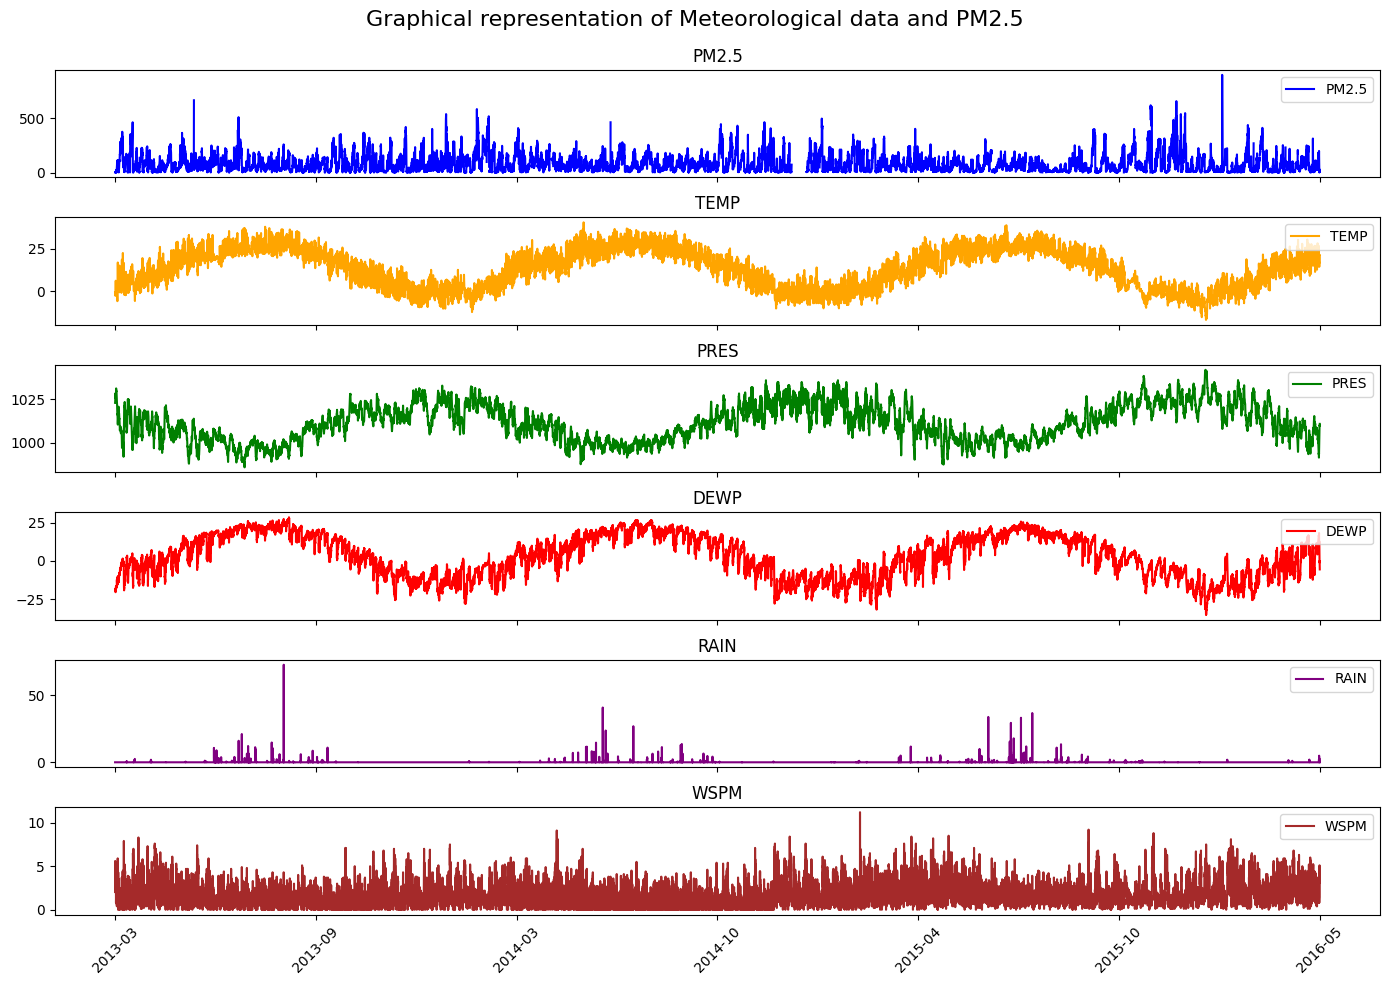

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming 'data' is your DataFrame with the mentioned columns

# Combine the separate date columns into a single datetime column
df['Date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Define the columns you want to plot
columns_to_plot = ['PM2.5', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

# Define the colors for each plot
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# Create subplots with shared x-axis (date)
fig, axs = plt.subplots(len(columns_to_plot), 1, figsize=(14, 10), sharex=True)

# Plot each of the columns on a separate subplot
for ax, col, color in zip(axs, columns_to_plot, colors):
    ax.plot(df['Date'], df[col], label=col, color=color)
    ax.set_title(col)
    ax.legend(loc='upper right')

# Rotate the date labels to avoid overlap
plt.setp(axs, xticks=df['Date'][::len(df)//6], xticklabels=df['Date'].dt.strftime('%Y-%m')[::len(df)//6])
plt.xticks(rotation=45)

# Ensure the main title and subplots do not overlap and adjust spacing
plt.tight_layout()
plt.subplots_adjust(top=0.92)

# Add a main title above all subplots
fig.suptitle('Graphical representation of Meteorological data and PM2.5', fontsize=16)


# Show the plot
plt.show()


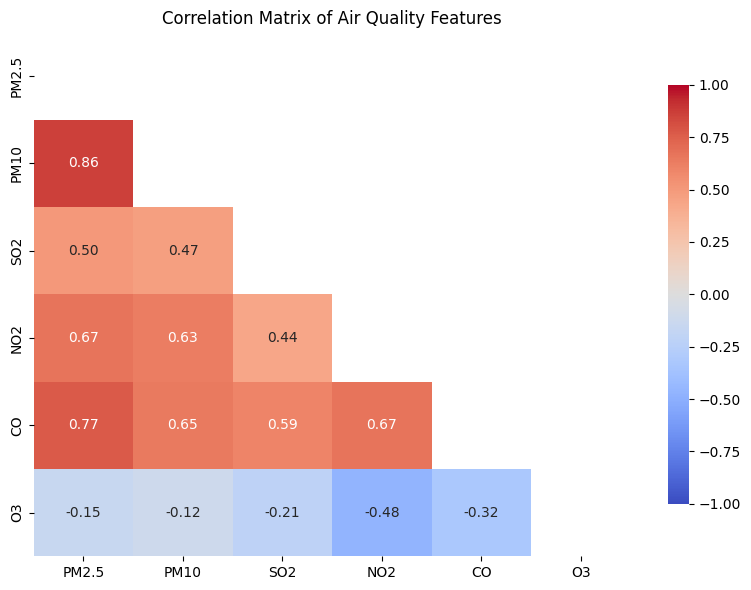

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your pandas DataFrame and it contains the relevant columns
# For example: data = pd.read_csv('your_file.csv')

# Calculate the correlation matrix
corr = df[['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']].corr()

# Create a mask to display only the lower triangle of the matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap with the mask
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            vmin=-1, vmax=1, cbar_kws={"shrink": .8})

# Add title
plt.title('Correlation Matrix of Air Quality Features')

# Adjust layout to fit
plt.tight_layout()


# Show the plot
plt.show()


In [ ]:
# df.dropna(subset=['PM2.5'], inplace=True)
features = ['PM2.5', 'TEMP', 'NO2', 'SO2', 'RAIN']
df.dropna(subset=features, inplace=True)

In [ ]:
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,Date
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,2013-03-01 00:00:00
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,2013-03-01 01:00:00
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,2013-03-01 02:00:00
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin,2013-03-01 03:00:00
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin,2013-03-01 04:00:00


In [ ]:
# Assuming 'df' is your DataFrame containing the dataset
# Adjust the column indices according to your DataFrame structure
features_columns = ['PM2.5', 'TEMP', 'NO2', 'SO2', 'RAIN']  # Use the actual column names from your DataFrame

# Select all rows for these features
training_set = df[features_columns].values

# Check the length of the training_set
length_of_training_set = len(training_set)
print(length_of_training_set)


26826


In [ ]:
training_set = training_set[-5000:]

**Feature Scaling**

In [ ]:
# normalize your data for BiGRU
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
lag = 48  # Number of hours to use as input to predict the next hour
n_obs = 5000  # Adjust this if needed based on your dataset size after preprocessing
features = 5  # Total number of features included

X_train = []
y_train = []

# Ensure you're selecting all features for X_train and only the PM2.5 values for y_train
for i in range(lag, n_obs):
    X_train.append(training_set_scaled[i-lag:i, :])  # Include all features in the lagged window
    y_train.append(training_set_scaled[i, 0])  # Assuming PM2.5 is the first feature for prediction

# Convert lists to numpy arrays for training the BiGRU
X_train, y_train = np.array(X_train), np.array(y_train)

# Now, X_train should have the shape [samples, timesteps, features]
print(X_train.shape)  # Expected shape: (number of samples, lag, features)



(4952, 48, 5)


In [ ]:
X_train.shape

(4952, 48, 5)

# **BI GRU**

without tuning hyperparameters

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()

# Adding the first Bidirectional GRU layer with 200 units
model.add(Bidirectional(GRU(units=200, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.1))  # Applying 10% dropout

# Adding a second Bidirectional GRU layer with 100 units
model.add(Bidirectional(GRU(units=100, return_sequences=True)))
model.add(Dropout(rate=0.1))  # Applying 10% dropout

# Adding the third Bidirectional GRU layer with 50 units, return_sequences=True allows stacking another GRU layer
model.add(Bidirectional(GRU(units=50, return_sequences=True)))
model.add(Dropout(rate=0.1))  # Applying 10% dropout

# Adding the last Bidirectional GRU layer with 50 units
# This is the last GRU layer, so return_sequences is not needed
model.add(Bidirectional(GRU(units=50)))
model.add(Dropout(rate=0.1))  # Applying 10% dropout

# Adding the output layer
model.add(Dense(units=1))

In [ ]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirecti  (None, 48, 400)           248400    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 48, 400)           0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 48, 200)           301200    
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 48, 200)           0         
                                                                 
 bidirectional_6 (Bidirecti  (None, 48, 100)           75600     
 onal)                                                           
                                                      

Fitting the BI GRU to the Training set

In [ ]:
# Compiling the BiGRU
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
155/155 [==============================] - 78s 406ms/step - loss: 0.0039
Epoch 2/50
155/155 [==============================] - 64s 412ms/step - loss: 0.0016
Epoch 3/50
155/155 [==============================] - 63s 405ms/step - loss: 0.0013
Epoch 4/50
155/155 [==============================] - 63s 404ms/step - loss: 0.0012
Epoch 5/50
155/155 [==============================] - 63s 402ms/step - loss: 0.0012
Epoch 6/50
155/155 [==============================] - 63s 407ms/step - loss: 0.0010
Epoch 7/50
155/155 [==============================] - 63s 404ms/step - loss: 9.7324e-04
Epoch 8/50
155/155 [==============================] - 63s 406ms/step - loss: 0.0010
Epoch 9/50
155/155 [==============================] - 62s 401ms/step - loss: 0.0011
Epoch 10/50
155/155 [==============================] - 62s 403ms/step - loss: 0.0010
Epoch 11/50
155/155 [==============================] - 62s 404ms/step - loss: 9.9313e-04
Epoch 12/50
155/155 [==============================] - 62s 401ms/s

Making the predictions and visualising the results

In [ ]:
# Assuming 'sc' is your MinMaxScaler fitted on the training data
# And 'dataset_test' is your raw test dataset loaded from '/content/Test.csv'

# Load the test dataset (already done)
dataset_test = pd.read_csv('/content/Test.csv')

# Drop rows with NaN values in any of the columns you're using
dataset_test.dropna(subset=['PM2.5', 'TEMP', 'NO2', 'SO2', 'RAIN'], inplace=True)

# Scale the test data using the same scaler as the training data
# Make sure to select the same features in the same order as the training set
test_features = dataset_test[['PM2.5', 'TEMP', 'NO2', 'SO2', 'RAIN']].values
test_features_scaled = sc.transform(test_features)

# Prepare sequences for testing
X_test = []
for i in range(lag, len(test_features_scaled)):
    X_test.append(test_features_scaled[i-lag:i])  # Use all features

X_test = np.array(X_test)

# Reshape X_test if necessary (it might already be in the correct shape)
# X_test should now be shaped [samples, timesteps, features]
# No need to reshape based on the previous step since it already considers all features

# Make predictions
pred_PM2 = model.predict(X_test)

# Depending on your model's output, you might need to inverse scale the predictions
# If you scaled your target variable (PM2.5) during training


210/210 [==============================] - 26s 109ms/step


In [ ]:
pred_PM2 = model.predict(X_test)
pred_PM2

210/210 [==============================] - 23s 110ms/step


array([[0.05092757],
       [0.06231739],
       [0.06034362],
       ...,
       [0.02910068],
       [0.03572857],
       [0.04038765]], dtype=float32)

In [ ]:
# Assume pred_PM2 is your predictions with shape (num_samples, 1)
# Create an array with the same number of columns as the original scaled data
pred_full = np.zeros((pred_PM2.shape[0], 5))  # 5 for the number of features you have

# Assuming PM2.5 is the first column, fill in your predictions there
pred_full[:, 0] = pred_PM2.ravel()  # Use ravel() to ensure it's a 1D array

# Perform the inverse transformation
pred_full_inverse = sc.inverse_transform(pred_full)

# Extract the PM2.5 predictions after inverse transforming
pred_PM2_inverse = pred_full_inverse[:, 0]



In [ ]:
# Assuming dataset_test is your test DataFrame and it's already preprocessed to drop NaNs as before
real_PM2 = dataset_test['PM2.5'].values[-len(pred_PM2):]  # Make sure to align the lengths

# Ensure real_PM2 is properly shaped for comparison
# If necessary, reshape it (though it should already be a 1D array matching pred_PM2_inverse in length)
real_PM2 = real_PM2.reshape(-1, 1)  # Only needed if real_PM2 isn't already a 1D array

# Now proceed with RMSE calculation
RMSE = np.sqrt(np.mean((pred_PM2_inverse - real_PM2.ravel())**2))  # Use ravel() to ensure it's 1D for calculation
print("RMSE:", RMSE)


RMSE: 21.261221183520515


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(real_PM2, pred_PM2_inverse))

# Calculate MAE
mae = mean_absolute_error(real_PM2, pred_PM2_inverse)

# Calculate MSE
mse = mean_squared_error(real_PM2, pred_PM2_inverse)

# Calculate MAPE - Note: You have to ensure real_PM2 does not contain zeros to avoid division by zero
mape = np.mean(np.abs((real_PM2 - pred_PM2_inverse) / real_PM2)) * 100

# Calculate R-squared
r2 = r2_score(real_PM2, pred_PM2_inverse)

# Print the results
print('RMSE: {:.4f}'.format(rmse))
print('MAE: {:.4f}'.format(mae))
print('MSE: {:.4f}'.format(mse))
print('MAPE: {:.4f}%'.format(mape))
print('R-squared: {:.4f}'.format(r2))

RMSE: 21.2612
MAE: 13.1743
MSE: 452.0395
MAPE: 302.7855%
R-squared: 0.9366


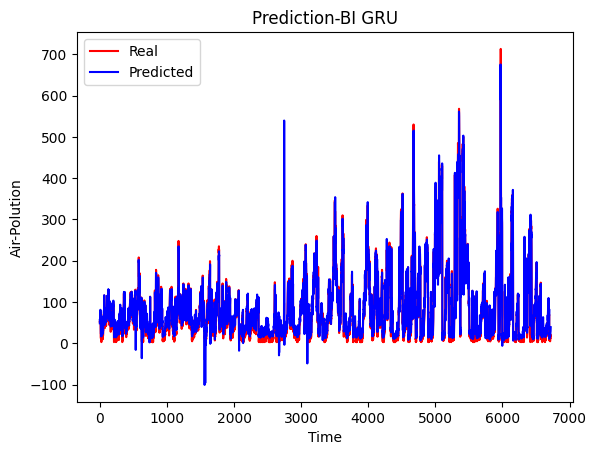

In [ ]:
plt.plot(real_PM2, color = 'red', label = 'Real')
plt.plot(pred_PM2_inverse, color = 'blue', label = 'Predicted')
plt.title('Prediction-BI GRU')
plt.xlabel('Time')
plt.ylabel('Air-Polution')
plt.legend()
plt.show()

Variable importance

In [ ]:
import numpy as np
import pandas as pd

# Assuming dataset_test is your pandas DataFrame with the original unscaled test features
# And sc is the MinMaxScaler instance you've fitted on the entire feature set

# Extract the scaling parameters for the PM2.5 feature
pm25_scaler_min = sc.min_[dataset_test.columns.get_loc('PM2.5')]
pm25_scaler_scale = sc.scale_[dataset_test.columns.get_loc('PM2.5')]

# Define the lag based on how many time steps back you used when creating sequences
lag = 48  # The lag you used when creating your X_test

# Create y_test using the true values of PM2.5 that immediately follow each sequence in X_test
y_test = dataset_test['PM2.5'].values[lag:lag+X_test.shape[0]]

# Manually apply the inverse transformation for PM2.5
y_test_unscaled = y_test * pm25_scaler_scale + pm25_scaler_min

# y_test_unscaled now contains the actual PM2.5 values in their original scale



206/206 [==============================] - 25s 119ms/step


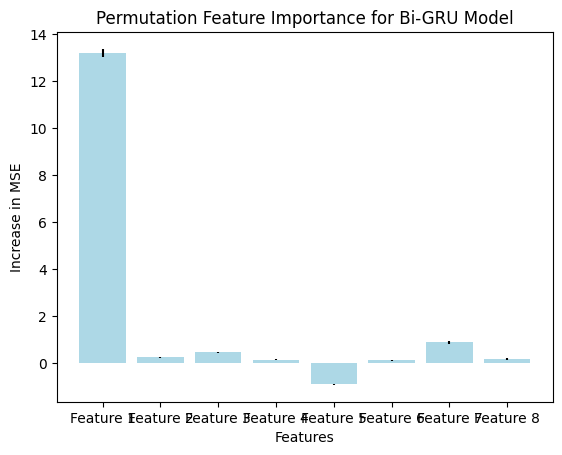

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model

def calculate_feature_importance(model, X_test, y_test, n_features, n_repeats=10):
    # Make sure that X_test is a numpy array and it has three dimensions [samples, timesteps, features]
    assert len(X_test.shape) == 3, "X_test must be a 3D array for BI-GRU models"

    # Store the original model predictions
    original_preds = model.predict(X_test)
    original_mse = mean_squared_error(y_test, original_preds)

    # Initialize an array to hold the importances for each feature
    importances = np.zeros((n_features, n_repeats))

    # Permute each feature and calculate the change in model's performance
    for i in range(n_features):
        for j in range(n_repeats):
            # Create a copy of the dataset to shuffle the feature
            X_test_permuted = np.copy(X_test)
            # Permute the selected feature across all samples and timesteps
            np.random.shuffle(X_test_permuted[:, :, i])

            # Calculate the model's MSE with the permuted data
            permuted_preds = model.predict(X_test_permuted)
            permuted_mse = mean_squared_error(y_test, permuted_preds)

            # The importance is the difference in performance
            importances[i, j] = permuted_mse - original_mse

    # Compute average and standard deviation of importances
    mean_importances = np.mean(importances, axis=1)
    std_importances = np.std(importances, axis=1)

    # Visualize the importances
    plt.bar(range(n_features), mean_importances, yerr=std_importances, color='lightblue')
    plt.xticks(range(n_features), [f'Feature {i+1}' for i in range(n_features)])
    plt.xlabel('Features')
    plt.ylabel('Increase in MSE')
    plt.title('Permutation Feature Importance for Bi-GRU Model')
    plt.show()

    return mean_importances, std_importances

# Load your trained Bi-GRU model
# model = load_model('path_to_your_bi_gru_model.h5')

# Prepare your test data: X_test and y_test
# X_test is assumed to be shaped [samples, timesteps, features]
# y_test is assumed to be the actual PM2.5 values corresponding to X_test

n_features = X_test.shape[2]  # Number of features in X_test

# Calculate permutation importance
feature_importances, feature_importances_std = calculate_feature_importance(model, X_test, y_test, n_features)

